<a href="https://colab.research.google.com/github/rahul-tuladhar/SmartCityDeepLearning/blob/master/Final_Copy_of_Multi_file_13dim_lstm2_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
This `ipynb` demos the adaption of previous single-dimension LSTM to mulit-dimensional LSTM for multi-step predictions. Thie main LSTM neural network is implemented in [`PyTorch`](https://pytorch.org/) . This neural network attempts to explore the possibility of predicting future values for simulation data generated by  [SUMO](https://sumo.dlr.de/wiki/Simulation_of_Urban_MObility_-_Wiki) a simulator for urban mobility. 

There are several kinds of data generated by SUMO. By interfacing with SUMO's [Python](https://python.org) API called [ TraCI](https://sumo.dlr.de/wiki/TraCI), data for edges, traffic lights, lanes, etc. In this case, data taken from edges and traffics lights were generated to be used as input into the neural network.

# **Why PyTorch?**
There are several kinds of machine learning frameworks. I wanted to explore one of these frameworks, largely because of my previous experience with it. 

# ** Why LSTM?**
A LSTM neural network is a form of recurrent neural network (RNN). Instead of a collection of neurons, there are Long-Short Term Memory cells that are connected together in layers similiar to other RNN networks. This [link](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) provides further information on the details of LSTM's and what they are used for. 



# **MODULES**
Import statements need for the neural network.
The main modules for this file include:


1.   `sci-kit learn`: Used for scaling (`MinMaxScaler`) and splitting the data.
2.   `pandas`: Framework for interacting with the data.
3.   `numpy`: scientific package commonly used in deep learning.
4.   `matplotlib`: Plotting the error values and accuracy curves.
5.   `torch`: The PyTorch package necessary for the LSTM network used to predict the time-series data.

Helper Modules:
1.    `math`: Math!
2.     `tqdm`: This [library](https://pypi.org/project/tqdm/) is a useful progress bar that has intergration with `.ipynb`.


In [34]:
import math
import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore') # suppresses warnings in the MinMaxScaler()

from __future__ import print_function
from os.path import exists
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tqdm import tqdm, tqdm_notebook # progress bar useful for iterating through data structures


torch.manual_seed(1)


# Google Cloud 
These statements are necessary for interacting with the data found in google drive. Using google.collab running on their hosted runtime makes it easy to interact and store files inputted and generated from scripts on google.collab. 

The `BASE_DIR` in this case is hardcoded to the directory which has all the files I needed for the python notebooks to run.

In [35]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/SmartCity Research/Python Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Extra experimental stuff
# source: https://www.machinelearningplus.com/python/parallel-processing-python/
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


# CUDA 

PyTorch is useful as a framework because of its developed GPU hardware integration within its implementation. The framework makes its easier to put the data on either the CPU or GPU depending on what runtime instance the notebook runs on. On google.collab, there are at this moment 3 kinds of runtime instance: CPU, GPU, and TPU. Both the GPU and TPU aim to be optimized for machine learning tasks. CUDA is the PyTorch implementation of using GPU for the neural network which makes the training process faster. 

In [37]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_parallel = False  # For parallelization of data
device_count = torch.cuda.device_count()

print("Using Cuda: {}".format(use_cuda))
print("Device count: {}".format(device_count))

Using Cuda: True
Device count: 1


# **Helper Functions**


*   `traverse_dir`: Identifies all file names in the directory.

> Parameters:
> -   `dir_name`: string for the directory for all file names to be 
> -   `return`: list of strings for filenames within the directory

*   `prepare_df`: Converts `.csv` file into 2 dataframes; `test` and `train`. The data was arbitrarily split 2-1 train-test. 

> Parameters:
> -   `path`: string for reading in a particular .csv file
> -   `return`: train and test sets as dataframes

*   `normalize_df`: Uses the `sklearn` `MinMaxScaler()` object to scale the raw values to the range `[0,1]`.

> Parameters:
> -   `dataframe`: dataframe to be normalized 
> -   `return`: dataframe that's normalized, sklearn scaler used

*   `inverse_normalize_df`: Uses the given `sklearn` `MinMaxScaler()` object to inverse the scaling done on the dataframe.

> Parameters:
> -   `dataframe`: dataframe to be de-normalized
> -   `scaler`: sklearn scaler associated with the dataframe to be de-normalized
> -   `return`: dataframe that's de-normalized

*   `prepare_tensors`: 

> -   Parameters:
>  -   `training`: 2D numpy array. 
>  -   `target`: 2D numpy array.
>  -   `testing`: 2D numpy array.
>  -   `test_target`: 2D numpy array.
>  -   `return`: Tensor form of all the input parameters.



In [0]:
def traverse_dir(dir_name):
  file_names = []
  for dirName, subdirList, fileList in os.walk(dir_name):
      for fname in fileList:
          file_names.append(fname)
  return file_names

In [0]:
def prepare_df(path, col_names):
    df = pd.read_csv(path, names=col_names, engine='python')
    train = df.iloc[1: 2* len(df)//3]
    test = df.iloc[2 *len(df)//3:]
    return train, test

In [0]:
def normalize_df(dataframe):
    scaler = MinMaxScaler()
    df_norm = scaler.fit(dataframe)
    df_norm = scaler.transform(dataframe)
    return df_norm.astype(np.double, copy=False), scaler

In [0]:
def inverse_normalize_df(dataframe, scaler):
    dataframe = scaler.inverse_transform(dataframe)
    return dataframe

In [0]:
def prepare_tensors(training, train_target, testing, test_target):
  # If the train_norm is using minmax scaler
    train_tensor = torch.from_numpy(training).to(device=device)
    target_tensor = torch.from_numpy(train_target).to(device=device)
    test_tensor = torch.from_numpy(testing).to(device=device)
    test_target_tensor = torch.from_numpy(test_target).to(device=device)
    return train_tensor, target_tensor, test_tensor, test_target_tensor

In [0]:
# Maybe parallelize this? This seems like a bottle neck for many files
def get_dataset(dir_path, file_names, col_names):
  num_files = len(file_names)
  train_array = []
  test_array  =[]
  
  feats = ['step','noise', 'num_veh', 'num_lane', 'wait_time', 'occupancy', 'fuel', 'electricity', 'co','co2', 'hc', 'nox', 'pmx']
  
  for name in tqdm_notebook(file_names, desc='Getting data from filenames...'):
      train, test = prepare_df(dir_path+name, col_names)
      train = train[feats]
      test = test[feats]      
      train_array.append(train.values[1:,:])
      test_array.append(test.values[1:,:])
      
  train_array = np.array(train_array, dtype='f')
  test_array = np.array(test_array, dtype='f')
#   print("train {} test {}".format(train.shape,test.shape))
  return train_array, test_array      


In [0]:
def split_data(train, test, train_size, test_size):
  # Takes in numpy arrays?
  
  train_steps = len(train[0])
  test_steps = len(test[0])
  train_array = []
  target_array  = []
  test_array  = []
  test_target_array  = []
  
  if train_size < train_steps and test_size < test_steps:
    for train_sample,test_sample in tqdm_notebook(zip(train, test)):
      train_trunc = train_sample[:train_size,:]
      test_trunc = test_sample[:test_size,:]
      target = train_sample[1:train_size+1,:]
      test_target = test_sample[1:test_size+1,:]
      train_array.append(train_trunc)
      target_array.append(target)
      test_array.append(test_trunc)
      test_target_array.append(test_target)
  else:
    print("Error: Either train_size {} > {} train_steps , or test_size {} > {} test_steps".format(train_size, train_steps, test_size, test_steps))
  
  train_array = np.array(train_array, dtype='f')
  target_array  = np.array(target_array, dtype='f')
  test_array  = np.array(test_array, dtype='f')
  test_target_array  = np.array(test_target_array, dtype='f')
  return train_array , target_array , test_array , test_target_array

In [0]:
### Data parameters ###
NUM_FILES = 10000
BASE_DIR = '/content/drive/My Drive/SmartCity Research/'
# DIR = 'Edge Data/edge_data-12-45-52-March-18-2019/'
DIR = 'Edge Data/edge_data-1000-10000-02-02-53-April-15-2019/' # Needs trailing slash at the end
file_names = traverse_dir(BASE_DIR + DIR)[:NUM_FILES]

# names = ['step', 'street_name', 'co', 'co2', 'noise', 'num_veh','ped','hc_emission','nox_emission']
names = ['step','street_name','noise', 'num_veh', 'num_lane', 'wait_time', 'occupancy', 'fuel', 'electricity', 'co','co2', 'hc', 'nox', 'pmx', 'ped']


In [0]:
# print(file_names) # sanity check to see if file names are available

# **Data**

 The data I used contains completely random values so as I can illustrate that the multi-dimension LSTM training and prediction works. The predictions are not meant to be useful. 

The dimensions of the input `data` is (`batch_size`, `time_steps`,  `num_features`); in this case (100, 1000, 4).
 
*   `get_data`: Calls on the helper functions `prepare_df` and `normalize_df` to convert `.csv` files into `` objects.

> -   Parameters:
>  -   `dir_path`: dataframe to be de-normalized
>  -   `file_names`: list of strings of file names for given data type.
>  -   `train_size`: Integar number of  time-steps per file for training set.
>  -   `test_size`: Integar number of  time-steps per file
>  -   `return`: `torch` objects representing 3D matrix of dim `[batch_size, time_steps,num_features]`
        - `train_tensor`: 
        - `target_tensor`:
        - `test_tensor`:
        - `test_target_tensor`:


In [47]:
# training_data, target_data, test_data, test_target_data = get_data(BASE_DIR + DIR, file_names, names)

training_data, test_data = get_dataset(BASE_DIR + DIR, file_names, names)


In [0]:
### Dataset Parameters ###

TRAIN_SIZE = 100
TEST_SIZE = 50

### Scalers  ###
tr_scaler = MinMaxScaler() # training scaler
ts_scaler = MinMaxScaler() # testing scaler
tr_target_scaler = MinMaxScaler() # training target scaler
ts_target_scaler = MinMaxScaler() # testing target scaler

In [49]:
training_data , target_data , test_data , test_target_data = split_data(training_data, test_data, TRAIN_SIZE, TEST_SIZE)

In [50]:
print('train_tensor.shape',training_data.shape)
train_shape = training_data.shape
# print('train_tensor',training_data)
print('target.shape',target_data.shape)
target_shape = target_data.shape

# print('target',target_data)
print('test_input.shape',test_data.shape)
test_shape = test_data.shape
# print('test',test_data)
print('test_target.shape',test_target_data.shape)
test_target_shape = test_target_data.shape
# print('test_target',test_target_data)

train_tensor.shape (10000, 100, 13)
target.shape (10000, 100, 13)
test_input.shape (10000, 50, 13)
test_target.shape (10000, 50, 13)
train_tensor.shape (10000, 100, 13)
target.shape (10000, 100, 13)
test_input.shape (10000, 50, 13)
test_target.shape (10000, 50, 13)


In [51]:
# # Normalize
print(training_data.shape)
training_data_reshaped = training_data.reshape(-1,train_shape[2])
print(training_data_reshaped.shape)
training_data_norm, scaler = np.array(normalize_df(training_data_reshaped))
print(training_data_norm.shape)
# print(scaler)

(10000, 100, 13)
(1000000, 13)
(1000000, 13)
(10000, 100, 13)
(1000000, 13)
(1000000, 13)


In [52]:
target_data_reshaped = target_data.reshape(-1,target_shape[2])
print(target_data_reshaped.shape)
target_data_norm, tr_scaler = np.array(normalize_df(target_data_reshaped))
print(target_data_norm.shape)
# print(tr_scaler)

(1000000, 13)
(1000000, 13)
(1000000, 13)
(1000000, 13)


In [53]:
test_data_reshaped = test_data.reshape(-1,test_shape[2])
print(test_data_reshaped.shape)
test_data_norm, ts_scaler = np.array(normalize_df(test_data_reshaped))
print(test_data_norm.shape)
# print(ts_scaler)

(500000, 13)
(500000, 13)
(500000, 13)
(500000, 13)


In [54]:
test_target_data_reshaped = test_target_data.reshape(-1,test_target_shape[2])
print(test_target_data_reshaped.shape)
test_target_data_norm, ts_tr_scaler = np.array(normalize_df(test_target_data_reshaped))
print(test_target_data_norm.shape)
# print(ts_tr_scaler)

(500000, 13)
(500000, 13)
(500000, 13)
(500000, 13)


In [0]:
training_data = training_data_norm.reshape(train_shape) # hard coded values for now
target_data = target_data_norm.reshape(target_shape)
test_data = test_data_norm.reshape(test_shape)
test_target_data = test_target_data_norm.reshape(test_target_shape)
# print(training_data_norm_re)
# print(target_data_norm_re)
# print(test_data_norm_re)
# print(test_target_data_norm_re)

In [0]:
# train_tensor, target_tensor, test_tensor, test_target_tensor = prepare_tensors(training_data_norm_re[0], target_data_norm[0], test_data_norm[0], test_target_data_norm[0]) 
train_tensor, target_tensor, test_tensor, test_target_tensor = prepare_tensors(training_data, target_data, test_data, test_target_data) 
# 

In [0]:
# print('train_tensor.shape',train_tensor.shape)
# print('train_tensor',train_tensor)
# print('target.shape',target_tensor.shape)
# print('target',target)
# print('test_input.shape',test_tensor.shape)
# print('test',test)
# print('test_target.shape',test_target_tensor.shape)
# print('test_target',test_target)
# train_tensor.type(torch.DoubleTensor)
# target_tensor.type(torch.DoubleTensor)
# test_tensor.type(torch.DoubleTensor)
# test_target_tensor.type(torch.DoubleTensor)


# **LSTMTIMESERIES CLASS**

This class takes in a sequence of time series data and inputs it input the model bassed on the `nn.pytorch` module.

The `LSTMTimeSeries` class takes in 5 parameters: , , .
- `input_dim`: The number of input features.
- `hidden_dim`: The dimensions of the hidden layer of the LSTM. Set in this case to the number of input and output features.
- `batch_size`: The number of different samples.
- `use_batch`: Default value is usually `False`, but this model takes in input with dimension `(batch_size, num_time_steps, num_features)`.
- 




In [0]:
class LSTMTimeSeries(nn.Module):
  def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, 
               num_layers=1, batch_first=True, dropout=1):
    super(LSTMTimeSeries, self).__init__()
    self.hidden_dim = hidden_dim
    self.input_dim = input_dim
    self.batch_size = batch_size
    self.num_layers = num_layers
    
    # LSTM takes the time series steps as input, and outputs hidden states
    # with dimensionality hidden_dim
    self.lstm = nn.LSTM(input_dim, hidden_dim, self.num_layers)
    
    # We need a linear layer that maps the hidden state space to the predicted
    # state space
    
    self.linear = nn.Linear(self.hidden_dim, output_dim)
    
  def init_hidden(self):
    # We don't have any hidden state, until we init
    return (torch.zeros(self.batch_size, self.hidden_dim,device=device),
            torch.zeros(self.batch_size, self.hidden_dim,device=device))
  
  def forward(self, series):
    # Forward pass through LSTM layer
    # shape of lstm_out: [input_size, batch_size, hidden_dim]
    y_pred = self.linear(series)
    return y_pred
#     return y_pred.view(-1)
  

# Initialization of Network and Parameters

Initial parameters for the network include:
> - `INPUT_DIM`: The number of features (attributes/columns of the data set) used in the neural network.
> - `HIDDEN_DIM`: The number of features within the network layers. Default value is equivalent to `INPUT_DIM` for simplicity. (Need stronger citation/justification)
> - `BATCH_SIZE`: The number of time steps for a particular batch training set.
> - `TEST_SIZE`: The number of time steps for a particular batch's test sample set.

*NOTE: * For the initial trial of this network, there are hard coded values for these parameters. Sometimes if the dataset does not contain enough time-steps than then the parameters `BATCH_SIZE` and `TEST_SIZE` will have to be adjusted to the number of max time steps in the data sample. 

By default the `Sequence` class is cast to `double` in order for the matrix mulitplication to have all the same `numpy` primitive types. 

## Loss Criterion
**Mean Square Error** is commonly used in regression-like tasks similar to what this neural network aims to achieve in multi-step time-step prediction.  Other loss criterion may be used and their accuracies compared in, future work.

### Output Note


In [0]:
INPUT_DIM = 13
OUTPUT_DIM = 13
HIDDEN_DIM = 13
NUM_EPOCHS = 10000
NUM_LAYERS = 10
BATCH_SIZE = 10000
FUTURE = 50
LEARNING_RATE = 0.4
MOMENTUM = 0.9
model = LSTMTimeSeries(INPUT_DIM, HIDDEN_DIM, BATCH_SIZE, OUTPUT_DIM, NUM_LAYERS)
model.double().to(device=device)
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=MOMENTUM)
hist = np.zeros(NUM_EPOCHS)


# **Training**

Training involves the use of the `closure()` method which is a parameter fed into the `optimizer.step()` [function](https://pytorch.org/docs/stable/optim.html#optimizer-step-closure).  
As per PyTorch documentation 
```
Some optimization algorithms such as Conjugate Gradient and LBFGS need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model. The closure should clear the gradients, compute the loss, and return it.
```

## Predictions

Predictions are generated per epoch, as per the example on [PyTorch github](https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py). Here there are hard coded values for the number of steps to predict. In this ase the parameters are:
1.   Epochs: 5
2.   Future Time steps: 100

In [0]:

# #####################
# #  Train model
# #####################
# y_pred = None
# for t in tqdm_notebook(range(NUM_EPOCHS),desc='Training...'):
#     # Initialise hidden state
#     # Don't do this if you want your LSTM to be stateful
#     model.hidden = model.init_hidden()
    
#     # Forward pass
#     y_pred = model(train_tensor.double())
#     loss = criterion(y_pred, target_tensor)
#     if t % 500 == 0:
#         print("Epoch ", t, "TRAIN MSE: ", loss.item())
#     hist[t] = loss.item()

#     # Zero out gradient, else they will accumulate between epochs
#     optimizer.zero_grad()

#     # Backward pass
#     loss.backward()

#     # Update parameters
#     optimizer.step()
# print(y_pred)

In [63]:
#####################
#  Train model
#####################
y_pred = None
print("Epoch TRAIN/TEST MSE: ")
print("Parameters: BATCH SIZE, EPOCH, NUM LAYERS, LR, MOMENTUM")
print(" {} & {} & {} & {} & {}".format(BATCH_SIZE,NUM_EPOCHS, NUM_LAYERS, LEARNING_RATE, MOMENTUM) )
for t in tqdm_notebook(range(NUM_EPOCHS),desc='Training...'):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    model.train()
    # Forward pass
    y_pred = model(train_tensor.double())
    loss = criterion(y_pred, target_tensor)

    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    # batch_size = 30
    if t % 500 == 0 or t == NUM_EPOCHS-1:
      model.eval() # used when using dropout. Explicitly states you don't need to
                   # to have dropout on the last output layer
      test_loss = 0
      with torch.no_grad():
      #   for  in zip(test_tensor, test_target_tensor):
          inputs = test_tensor
          test_pred = model(inputs)
          test_loss = criterion(test_pred, test_target_tensor)
          test_hist[t] = test_loss.item()
      print(" {} & {:10.4f} & {:10.4f} \\\ ".format(t,loss.item(), test_loss)) 
          

print(y_pred)

 1000 &     0.0039 &     0.0042 \\ 
 1500 &     0.0028 &     0.0029 \\ 
 2000 &     0.0024 &     0.0024 \\ 
 2500 &     0.0021 &     0.0020 \\ 
 3000 &     0.0019 &     0.0018 \\ 
 3500 &     0.0018 &     0.0016 \\ 
 4000 &     0.0017 &     0.0015 \\ 
 4500 &     0.0016 &     0.0014 \\ 
 5000 &     0.0015 &     0.0013 \\ 
 5500 &     0.0014 &     0.0012 \\ 
 6000 &     0.0014 &     0.0011 \\ 
 6500 &     0.0013 &     0.0011 \\ 
 7000 &     0.0013 &     0.0010 \\ 
 7500 &     0.0012 &     0.0010 \\ 
 8000 &     0.0012 &     0.0009 \\ 
 8500 &     0.0012 &     0.0009 \\ 
 9000 &     0.0012 &     0.0009 \\ 
 9500 &     0.0011 &     0.0008 \\ 
 9999 &     0.0011 &     0.0008 \\ 

tensor([[[-3.9198e-03,  7.1612e-02,  4.0684e-03,  ..., -2.6272e-03,
          -2.6804e-03, -2.8482e-03],
         [ 6.1336e-03,  7.1462e-02,  4.0996e-03,  ..., -2.5304e-03,
          -2.6397e-03, -2.7913e-03],
         [ 2.2239e-02,  6.6767e-01,  1.4175e-02,  ...,  1.8026e-02,
           2.3092e-02,  2.0388e-02],


 0 &     0.0633 &     0.0612 \\ 
 500 &     0.0010 &     0.0006 \\ 
 1000 &     0.0009 &     0.0005 \\ 


In [0]:
def revert_data(original, scaler):
  tensor = inverse_normalize_df(original.reshape(-1,original.shape[2]).detach().cpu().numpy(), tr_scaler)
  tensor = tensor.reshape(original.shape)
  return tensor


predicted = inverse_normalize_df(y_pred.reshape(-1,y_pred.shape[2]).detach().cpu().numpy(), tr_scaler)
predicted_shaped = predicted.reshape(y_pred.shape) 
target_inv = inverse_normalize_df(target_tensor.reshape(-1,target_tensor.shape[2]).detach().cpu().numpy(), tr_scaler)
target_inv_shaped = target_inv.reshape(target_tensor.shape)
# print(predicted_shaped)
# print(target_inv_shaped)


Current size: [9.0, 16.0]


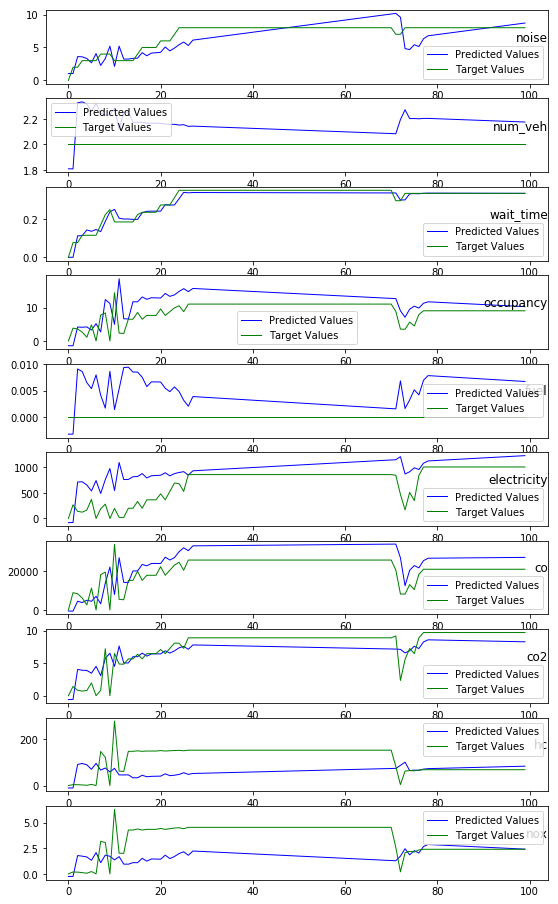

Current size: [9.0, 16.0]


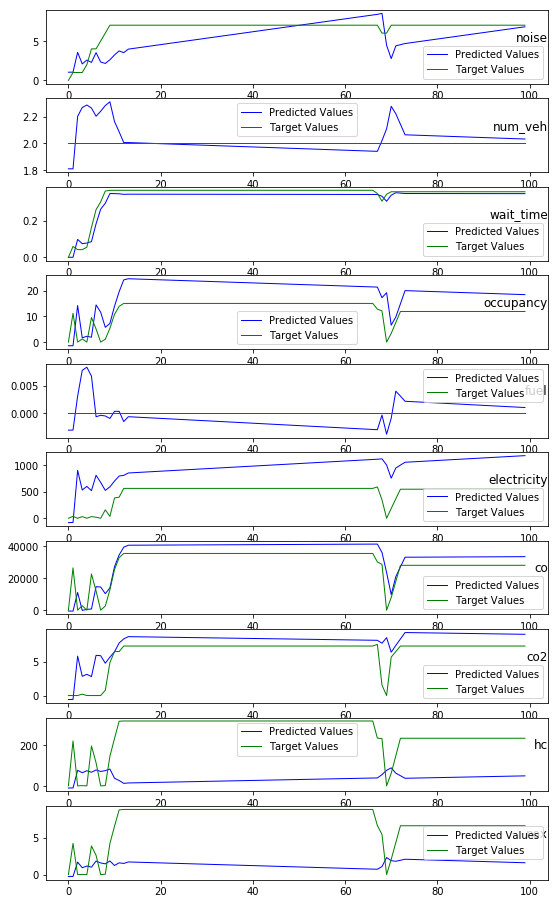

Current size: [9.0, 16.0]


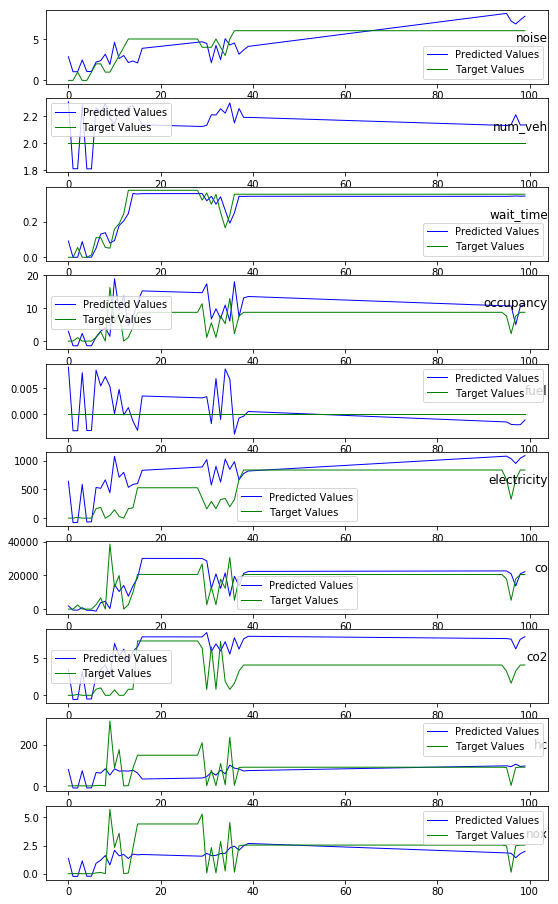

Current size: [9.0, 16.0]


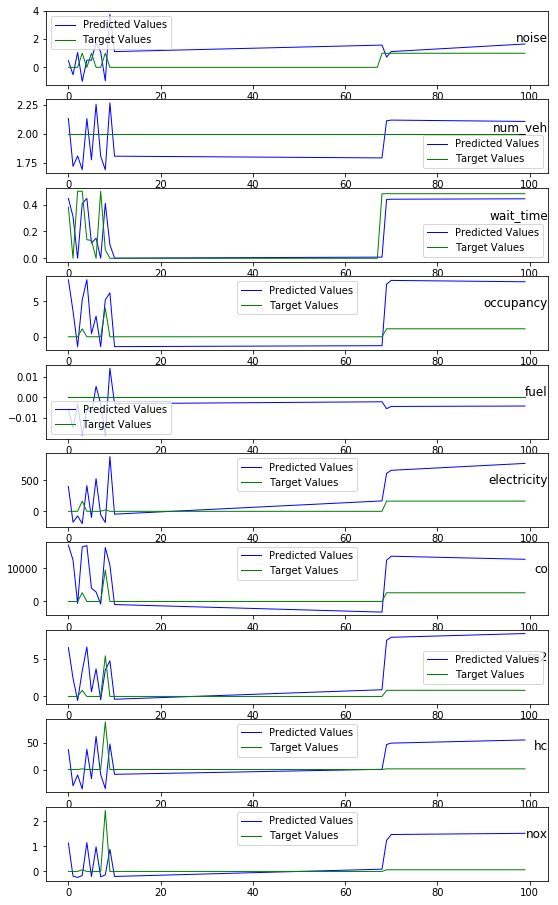

Current size: [9.0, 16.0]


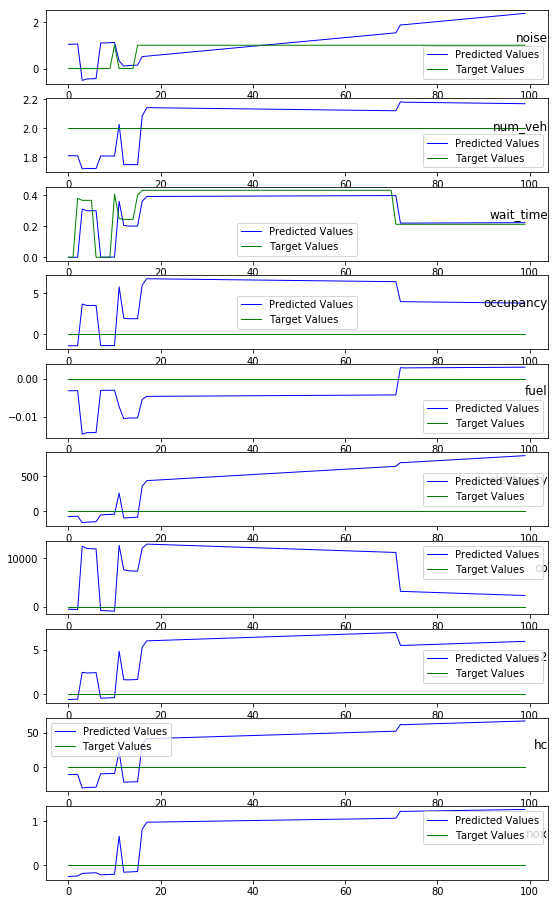

In [65]:
from matplotlib import pyplot
groups = [2,3,5,6,7,8,9,10,11,12]
# plot each column
v_list = predicted_shaped[:5]
v_target_list = target_inv_shaped[:5]
names = ['step','street_name','noise', 'num_veh', 'num_lane', 'wait_time', 'occupancy', 'fuel', 'electricity', 'co','co2', 'hc', 'nox', 'pmx', 'ped']

# print(values.shape)
# Get current size

def comparison_plot(values_list, values_target_list):
  for values, values_target in zip(values_list,values_target_list):
    pyplot.figure()
    i = 1
    for group in groups:
      pyplot.subplot(len(groups), 1, i)
      pyplot.plot(values[:, group], 'b-',label='Predicted Values', linewidth=1)
      pyplot.plot(values_target[:, group], 'g-', label='Target Values', linewidth=1)
      pyplot.title(names[group], y=0.5, loc='right')
      pyplot.legend()
      i += 1
    # Prints: [8.0, 6.0]

    fig_size = pyplot.rcParams["figure.figsize"]
    print("Current size:", fig_size)
    # Set figure width to 12 and height to 9

    fig_size[0] = 9
    fig_size[1] = 16
    pyplot.rcParams["figure.figsize"] = fig_size
    pyplot.show()

comparison_plot(v_list,v_target_list)

In [0]:
test_hist = np.zeros(NUM_EPOCHS)


In [67]:
test_pred = []
test_hist = np.zeros(NUM_EPOCHS)
model.eval()
test_loss = 0
with torch.no_grad():
#   for batch, batch_target in zip(test_tensor, test_target_tensor):
  inputs = test_tensor
  test_pred = model(inputs)
  test_loss = criterion(test_pred, test_target_tensor)
  test_hist[t] = test_loss.item()

print(test_loss)
# pyplot.figure()
# pyplot.plot(test_hist,'b' label='Test Loss',linewidth=1)
# pyplot.title('Test Loss')

tensor(0.0008, device='cuda:0', dtype=torch.float64)


torch.Size([10000, 50, 13])
(10000, 50, 13)
Current size: [9.0, 16.0]


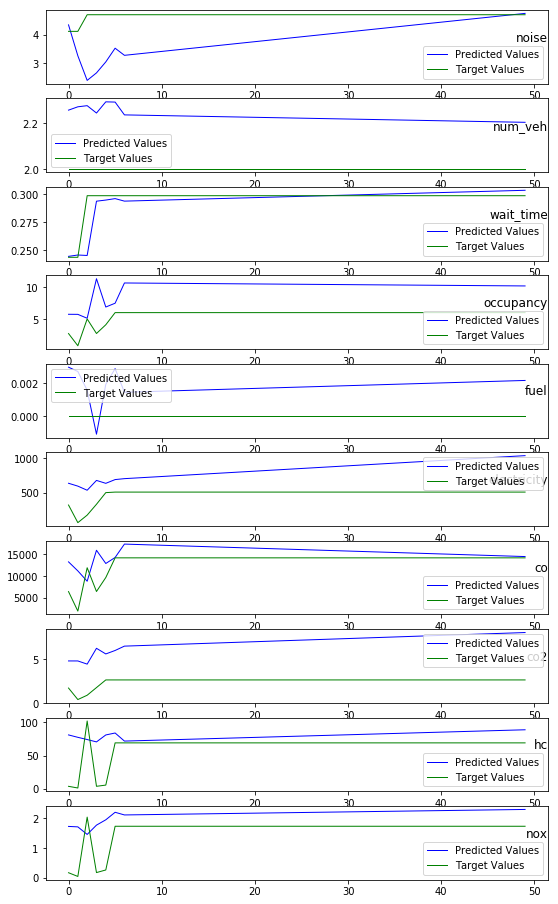

Current size: [9.0, 16.0]


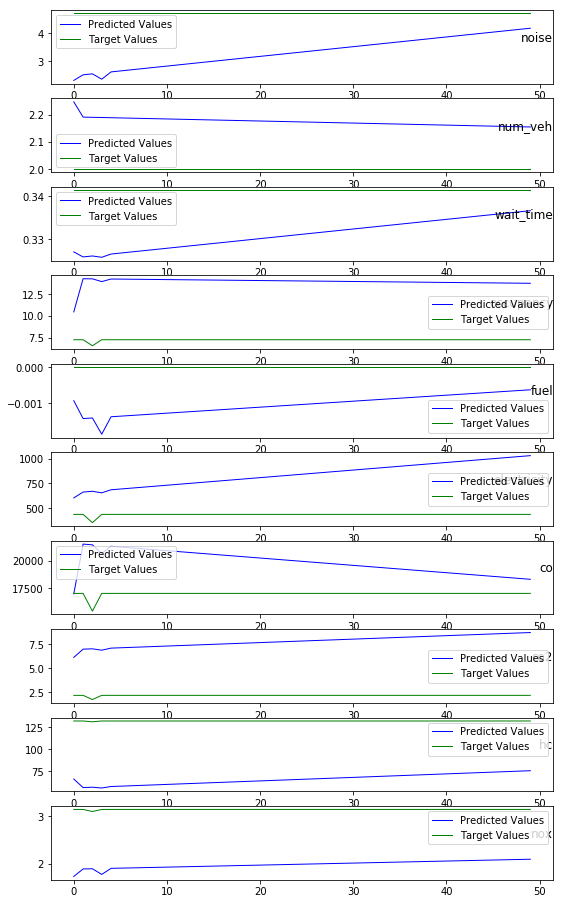

Current size: [9.0, 16.0]


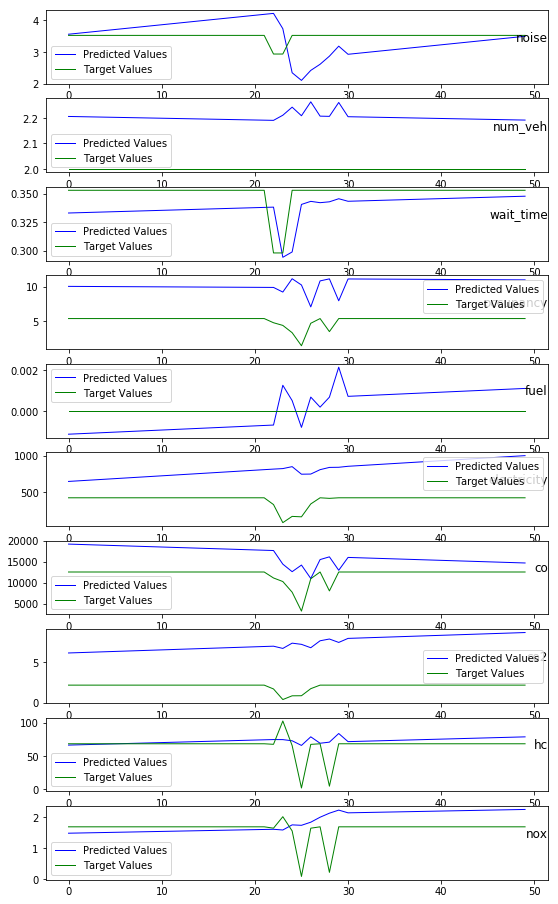

Current size: [9.0, 16.0]


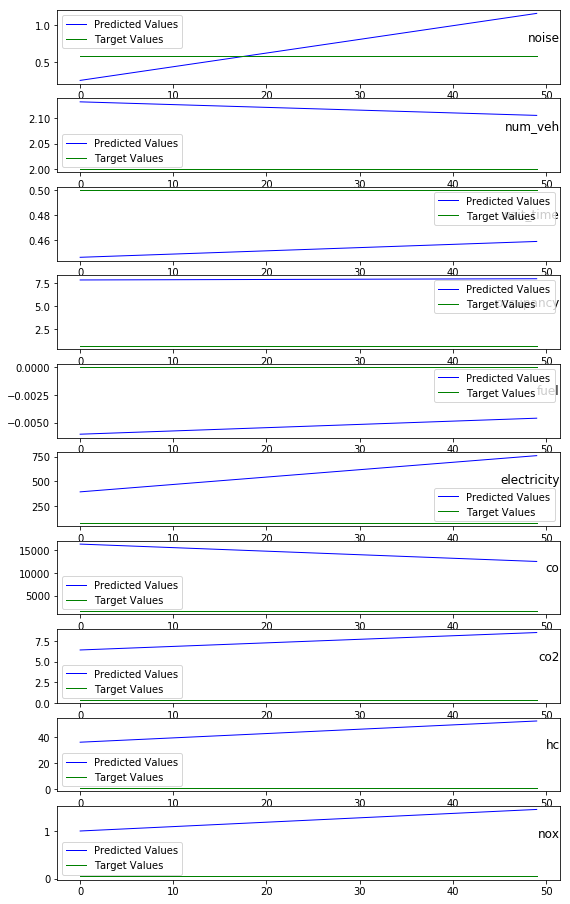

Current size: [9.0, 16.0]


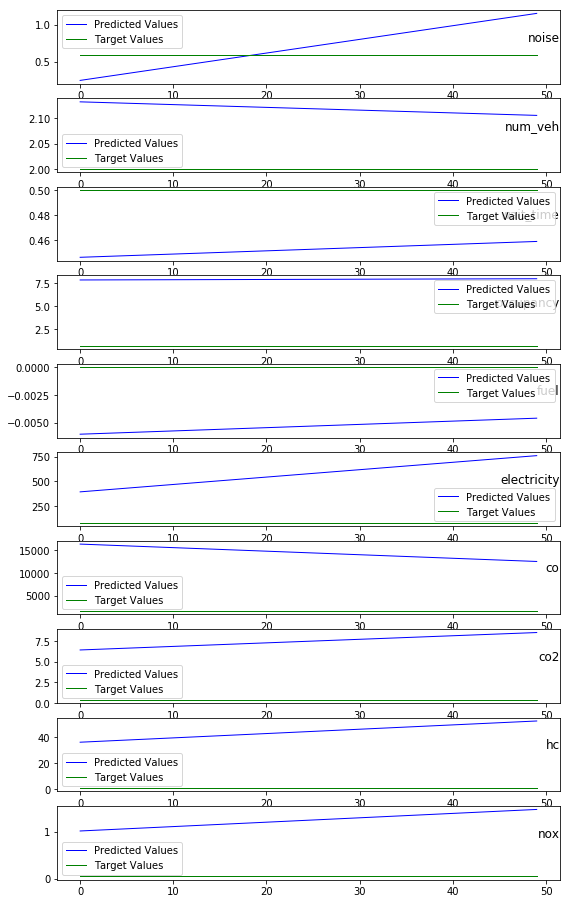

In [68]:
test_tensor_reverted = revert_data(test_target_tensor,ts_tr_scaler)
print(test_pred.shape)
print(test_tensor_reverted.shape)
test_pred_reverted = revert_data(test_pred, ts_tr_scaler)

comparison_plot(test_pred_reverted[:5], test_tensor_reverted[:5])


# **Summary**

## Work Completed
- Adapted a single dimension neural network to multi-dimension neural network.
- Generated readable output with decreasing train and test loss.
- Explored many ways in how not to implement a neural network in PyTorch (through trial and error...)

## Prediction Notes:
- There are negative values within the prediction.

## General Questions:
- How to improve accuracy?
- How to improve the learning of the values?
- How to test the learning of the neural network? 
- How confident can we say the network is learning the nonlinearity of the sequence?

## LSTM Questions
- How do additional layers affect the accuracy?
- How do additional features affect the accuracy?
- How does chaning the `HIDDEN_DIM` change the accuracy of the predictions?
